# Código Ruta Madre de Dios

In [1]:
#librerias
import pandas as pd
from geopy import distance
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from itertools import permutations

import folium
from folium import features

In [2]:
df= pd.read_excel("Coordenadas turísticas (Madre de Dios).xlsx")
%store df
df

Stored 'df' (DataFrame)


,Sitios turísticos de la región de Madre de Dios en Perú,Coordenadas
0,Parque Nacional Bahuaja-Sonene,"-13.392792935352029, -69.45073860682452"
1,Parque Nacional del Manu,"-12.040428939308635, -71.72300401810168"
2,Puerto Maldonado (Capital de la región),"-12.61091214919876, -69.20856082770615"
3,Reserva Nacional de Tambopata,"-12.931751326132385, -69.27268671623278"
4,Provincia de Tahuamanu,"-11.408620086641912, -69.50073070456547"


In [3]:
def string_to_tuple(string):
    numeros = string.split(', ')
    numero1 = float(numeros[0])
    numero2 = float(numeros[1])
    return (numero1, numero2)

df['Coordenadas'] = df['Coordenadas'].apply(string_to_tuple)
df

,Sitios turísticos de la región de Madre de Dios en Perú,Coordenadas
0,Parque Nacional Bahuaja-Sonene,"(-13.392792935352029, -69.45073860682452)"
1,Parque Nacional del Manu,"(-12.040428939308635, -71.72300401810168)"
2,Puerto Maldonado (Capital de la región),"(-12.61091214919876, -69.20856082770615)"
3,Reserva Nacional de Tambopata,"(-12.931751326132385, -69.27268671623278)"
4,Provincia de Tahuamanu,"(-11.408620086641912, -69.50073070456547)"


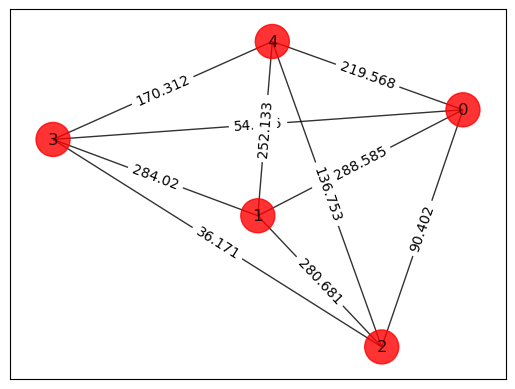

In [4]:
ciudades=[i for i in range(len(df))]
arcos = [(i,j) for i in ciudades for j in ciudades if i!=j]

distancia_arcos = {(i, j): round(distance.distance(df.iloc[i][1], df.iloc[j][1]).km, 3) for i, j in arcos}

n = len(ciudades)  
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

for edge, weight in distancia_arcos.items():
    G.add_edge(edge[0], edge[1], weight=weight)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G, seed=25)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=10)
    edge_labels = nx.get_edge_attributes(G, "weight")
    
draw_graph(G, colors, pos)

In [5]:
adj_matrix = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            adj_matrix[i, j] = temp["weight"]
print(adj_matrix)

[[  0.    288.585  90.402  54.536 219.568]
 [288.585   0.    280.681 284.02  252.133]
 [ 90.402 280.681   0.     36.171 136.753]
 [ 54.536 284.02   36.171   0.    170.312]
 [219.568 252.133 136.753 170.312   0.   ]]


order = (0, 1, 2, 3, 4) Distance = 995.317
order = (0, 1, 2, 4, 3) Distance = 930.867
order = (0, 1, 4, 2, 3) Distance = 768.1780000000001
order = (0, 3, 2, 4, 1) Distance = 768.1779999999999
Best order from brute force = (0, 3, 2, 4, 1) with total distance = 768.1779999999999


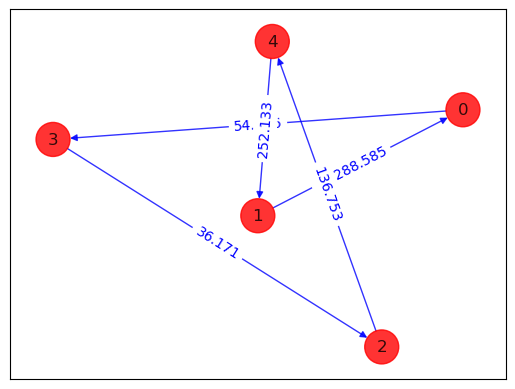

In [6]:
def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(G, best_order, colors, pos)

In [7]:
list_best_order = [(best_order[i], best_order[(i + 1) % len(best_order)]) for i in range(len(best_order))]
%store list_best_order
%store best_order

Stored 'list_best_order' (list)
Stored 'best_order' (tuple)


In [8]:
coord_mapa=[]
for n in range(len(df)):
    lista_aux=[]
    lista_aux.append(df.iloc[n][1][0])
    lista_aux.append(df.iloc[n][1][1])
    
    coord_mapa.append(lista_aux)
print(coord_mapa)
%store coord_mapa

[[-13.392792935352029, -69.45073860682452], [-12.040428939308635, -71.72300401810168], [-12.61091214919876, -69.20856082770615], [-12.931751326132385, -69.27268671623278], [-11.408620086641912, -69.50073070456547]]
Stored 'coord_mapa' (list)


In [9]:
nombres =[]
for n in range(len(df)):
    nombres.append(df.iloc[n][0])
print(nombres)

['Parque Nacional Bahuaja-Sonene', 'Parque Nacional del Manu', 'Puerto Maldonado (Capital de la región)', 'Reserva Nacional de Tambopata', 'Provincia de Tahuamanu']


In [10]:
mapa =folium.Map(location=[coord_mapa[0][0], coord_mapa[0][1]], zoom_start=7)

for i,j in list_best_order:
    linea=folium.PolyLine(locations=[[coord_mapa[i][0], coord_mapa[i][1]],
                                    [coord_mapa[j][0], coord_mapa[j][1]]], weight=1)
    mapa.add_child(linea)
    
    fg=folium.FeatureGroup(name="Direcciones")
    for n in range(len(df)):
        fg.add_child(folium.Marker(location=coord_mapa[n], 
                                   popup=folium.Popup(nombres[n])))
    mapa.add_child(fg)
mapa


In [11]:
%store distancia_arcos
distancia_arcos_filtrado = {arco: distancia_arcos[arco] for arco in list_best_order if arco in distancia_arcos}
%store distancia_arcos_filtrado

Stored 'distancia_arcos' (dict)
Stored 'distancia_arcos_filtrado' (dict)
